# LGBM Train



In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/RecSys2024/'
!pip3 install polars lightgbm pyarrow optuna optuna-integration

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DEBUG_MODE = True
#DEBUG_MODE = False
#OPTUNA_FLAG = True
OPTUNA_FLAG = False
#TRAIN_FRAC = 1.0 # train dataのnegative sampleをどれくらいsamplingするか
#TRAIN_FRAC = 0.8 # train dataのnegative sampleをどれくらいsamplingするか
TRAIN_FRAC = 0.6 # train dataのnegative sampleをどれくらいsamplingするか
#TRAIN_FRAC = 0.5 # train dataのnegative sampleをどれくらいsamplingするか
VALID_FRAC = 0.25 # validatoin dataをどれくらいsamplingするか
if DEBUG_MODE:
    TRAIN_FRAC = 1.0
    VALID_FRAC = 1.0

# next_read_timeとnext_scroll_percentageがほぼ0のものを除く
REMOVE_NOISE = True
remove_noise_name = ''
if REMOVE_NOISE:
    remove_noise_name = 'wo_noise'

train_type = 'train'
#train_type = 'valid' # use validation data as training for final sub

In [3]:
# ==================================================== # Library # ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import polars as pl
import joblib
import pyarrow
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, log_loss
# optuna
if OPTUNA_FLAG:
    import optuna.integration.lightgbm as lgb
else:
    import lightgbm as lgb
    print(lgb.__version__)

4.3.0


# Reading Input File

In [4]:
out_path = base_path + 'feature_output'
bins = [600, 3600, 3600 * 6]

# Feature Engineering

In [5]:
def read_files(train_type = 'train'):
    if DEBUG_MODE:
        # remove noiseに応じてpath変更
        if train_type == 'valid':
            impression = pl.read_parquet(f"{out_path}/small_{train_type}_impression.parquet")
            impression_article = pl.read_parquet(f"{out_path}/small_{train_type}_impression_article.parquet")
        else:
            impression = pl.read_parquet(f"{out_path}/{remove_noise_name}small_{train_type}_impression.parquet")
            impression_article = pl.read_parquet(f"{out_path}/{remove_noise_name}small_{train_type}_impression_article.parquet")
        user = pl.read_parquet(f"{out_path}/small_{train_type}_user.parquet")
        user_article = pl.read_parquet(f"{out_path}/small_{train_type}_user_article.parquet")
        article = pl.read_parquet(f"{out_path}/small_{train_type}_article.parquet")
    else:
        impression = pl.read_parquet(f"{out_path}/{train_type}_impression.parquet")
        impression_article = pl.read_parquet(f"{out_path}/{train_type}_impression_article.parquet")
        user = pl.read_parquet(f"{out_path}/{train_type}_user.parquet")
        user_article = pl.read_parquet(f"{out_path}/{train_type}_user_article.parquet")
        article = pl.read_parquet(f"{out_path}/{train_type}_article.parquet")
    return impression_article, impression, user, user_article, article

def add_pop_count(df, out_col_name, bins):

    for bin in bins:
        df = df.with_columns(
            (df["impression_time"] / bin).cast(pl.Int64).alias(f"time_bin_{bin}")
        )
        grouped_df = df.group_by([f"time_bin_{bin}", "article_id_inview"]).agg(
            pl.count().cast(pl.Int32).alias(out_col_name + str(bin))
        )
        df = df.join(
            grouped_df,
            on=[f"time_bin_{bin}", "article_id_inview"],
            how="left"
        )
        df = df.drop(f"time_bin_{bin}")
    return df


def join_features(impression_article, impression, user, user_article, article, bins):
    print('join features....')
    df = impression_article.select("impression_id", "article_id_inview", "clicked").join(impression, on="impression_id", how="inner")
    del impression_article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add view_cnt....')
    df = add_pop_count(df,"view_cnt", bins)
    df = reduce_mem_usage(df)

    print('add user features....')
    df = df.join(user, on="user_id", how="left")
    del user
    gc.collect()
    df = reduce_mem_usage(df)

    print('add article features....')
    df = df.rename({
        "article_id_inview": "article_id"
    })
    df = df.join(
        #article.rename({col: f"to_{col}" for col in article.columns}),
        article,
        on="article_id",
        how="left"
    )
    del article
    gc.collect()
    df = reduce_mem_usage(df)

    print('add user article features....')
    df = df.join(
        #user_article.rename({col: f"to_{col}" for col in user_article.columns if col != 'user_id'}),
        user_article,
        on=["user_id", "article_id"],
        how="left"
    )
    #df = df.drop(['user_id', 'article_id'])
    del user_article
    gc.collect()
    df = reduce_mem_usage(df)

    print('cast features....')
    for bin in bins:
        df = df.with_columns(
            pl.col(f"view_cnt{bin}").fill_null(0).cast(pl.Int32)
        )
    df = reduce_mem_usage(df)
    return df


def generate_unixtime_features(df, unixtime_list):

    for col_name in unixtime_list:
        df = df.with_columns(
            (pl.col("impression_time") - pl.col(col_name)).alias(f"{col_name}_diff").cast(pl.Int64)
        )
        df = df.drop(col_name)
    df = df.drop('impression_time')
    df = reduce_mem_usage(df)
    return df


def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data
    #return df_data, cat_cols


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage in Polars.
    """

    # Initialize an empty list to store optimized columns
    optimized_columns = []

    for col in df.columns:
        col_data = df[col]
        col_type = col_data.dtype

        if col_type in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt32]:
            col_data = col_data.fill_null(0)
            c_min = col_data.min()
            c_max = col_data.max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                optimized_columns.append(col_data.cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                optimized_columns.append(col_data.cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                optimized_columns.append(col_data.cast(pl.Int32))
            else:
                optimized_columns.append(col_data.cast(pl.Int64))
        elif col_type in [pl.Float32, pl.Float64]:
            c_min = col_data.min()
            c_max = col_data.max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                optimized_columns.append(col_data.cast(pl.Float32))
            else:
                optimized_columns.append(col_data.cast(pl.Float64))
        else:
            optimized_columns.append(col_data)
    # Create a new DataFrame with optimized columns
    optimized_df = pl.DataFrame({col: optimized_columns[i] for i, col in enumerate(df.columns)})

    return optimized_df


def cast_float_to_int(df, columns):
    for col in columns:
        df = df.with_columns(pl.col(col).cast(pl.Int64))
    return df


def negative_sampling(df, frac=0.5, seed=42):
    negative_examples = df.filter(pl.col("clicked") == False)
    positive_examples = df.filter(pl.col("clicked") == True)
    reduced_negatives = negative_examples.sample(fraction = frac, seed=seed)

    return pl.concat([reduced_negatives, positive_examples]).sort("impression_id")


def add_features(df, cols, key, prefix, df_origin = None):
    tmp = df.group_by(key).agg([
        pl.col(cols).mean(),
    ])
    new_cols = [prefix + name + "_mean" if name != key else name for name in cols]
    tmp = tmp.rename(dict(zip(cols, new_cols)))
    tmp = reduce_mem_usage(tmp)
    # joinする元のdfが異なる場合は最後の引数を指定する
    if df_origin is not None:
        df = df_origin
    df = df.join(tmp, on=key, how='left')
    del tmp
    gc.collect()

    # 差分のfeatureを追加
    for i, j in zip(cols, new_cols):
      df = df.with_columns(
          (pl.col(i) - pl.col(j)).alias('diff_' + j)
      )
    df = reduce_mem_usage(df)
    return df

def join_all_process(train_type='train'):

    impression_article, impression, user, user_article, article = read_files(train_type=train_type)
    # validはデータ量が多いので半分に削る
    if train_type == 'train':
      frac = TRAIN_FRAC
    else:
      frac = VALID_FRAC
    impression = impression.sample(fraction=frac, seed=42)
    float_int_cols = ['read_time', 'scroll_percentage']
    impression = cast_float_to_int(impression, float_int_cols)
    impression = reduce_mem_usage(impression)
    impression_article = reduce_mem_usage(impression_article)

    float_int_cols = ['u_read_time_last', 'u_scroll_percentage_last', 'u_impression_time_mean']
    user = cast_float_to_int(user, float_int_cols)
    user = reduce_mem_usage(user)

    float_int_cols = ['ua_read_time_last', 'ua_scroll_percentage_last']
    user_article = cast_float_to_int(user_article, float_int_cols)
    user_article = reduce_mem_usage(user_article)

    float_int_cols = ['a_total_read_time']
    article = cast_float_to_int(article, float_int_cols)
    article = reduce_mem_usage(article)

    df = join_features(impression_article, impression, user, user_article, article, bins)
    del impression_article, impression, user
    gc.collect()

    print('add user features group_by article impression basis, add diff features....')
    cols = ['read_time', 'scroll_percentage','device_type', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'view_num']
    df = add_features(df, cols=cols, key='article_id', prefix='a_')

    print('add article features group_by user impression basis, add diff features....')
    cols = ["premium", "total_inviews", "total_pageviews", "total_read_time", "sentiment_score", "title_len", "subtitle_len", "body_len", "image_ids_len", "ner_clusters_len", "entity_groups_len", "topics_len", "subcategory_len"]
    cols = ['a_' + i for i in cols]
    df = add_features(df, cols=cols, key='user_id', prefix='u_')

    print('add article features group_by user click history basis, add diff features....')
    user_hist = user_article.select("user_id", "article_id")
    del user_article
    gc.collect()

    user_hist = user_hist.join(article, on='article_id', how='left')
    del article
    gc.collect()

    user_hist = reduce_mem_usage(user_hist)
    df = add_features(user_hist, cols=cols, key='user_id', prefix='u_hist_', df_origin=df)
    del user_hist
    gc.collect()
    return df


In [6]:
valid = join_all_process('valid')

join features....
add view_cnt....
add user features....
add article features....
add user article features....
cast features....
add user features group_by article impression basis, add diff features....
add article features group_by user impression basis, add diff features....
add article features group_by user click history basis, add diff features....


In [7]:
if train_type == 'train':
    train = join_all_process('train')
else:
    train = valid

join features....
add view_cnt....
add user features....
add article features....
add user article features....
cast features....
add user features group_by article impression basis, add diff features....
add article features group_by user impression basis, add diff features....
add article features group_by user click history basis, add diff features....


In [8]:
# unixtimeのfeatureをdiffにする
unixtime_list = ['u_impression_time_last', 'u_impression_time_mean', 'ua_impression_time_mean', 'ua_impression_time_last', 'a_published_time', 'a_last_modified_time']
train = generate_unixtime_features(train, unixtime_list)
valid = generate_unixtime_features(valid, unixtime_list)

In [9]:
print(train.shape)
train.head()

(2244212, 124)


impression_id,article_id,clicked,read_time,scroll_percentage,device_type,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,view_num,view_cnt600,view_cnt3600,view_cnt21600,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,a_premium,a_article_type,a_category,a_category_str,a_total_inviews,a_total_pageviews,a_total_read_time,a_sentiment_score,a_sentiment_label,a_title_len,a_subtitle_len,a_body_len,a_ner_clusters_first,a_entity_groups_first,a_topics_first,…,diff_u_a_image_ids_len_mean,diff_u_a_ner_clusters_len_mean,diff_u_a_entity_groups_len_mean,diff_u_a_topics_len_mean,diff_u_a_subcategory_len_mean,u_hist_a_premium_mean,u_hist_a_total_inviews_mean,u_hist_a_total_pageviews_mean,u_hist_a_total_read_time_mean,u_hist_a_sentiment_score_mean,u_hist_a_title_len_mean,u_hist_a_subtitle_len_mean,u_hist_a_body_len_mean,u_hist_a_image_ids_len_mean,u_hist_a_ner_clusters_len_mean,u_hist_a_entity_groups_len_mean,u_hist_a_topics_len_mean,u_hist_a_subcategory_len_mean,diff_u_hist_a_premium_mean,diff_u_hist_a_total_inviews_mean,diff_u_hist_a_total_pageviews_mean,diff_u_hist_a_total_read_time_mean,diff_u_hist_a_sentiment_score_mean,diff_u_hist_a_title_len_mean,diff_u_hist_a_subtitle_len_mean,diff_u_hist_a_body_len_mean,diff_u_hist_a_image_ids_len_mean,diff_u_hist_a_ner_clusters_len_mean,diff_u_hist_a_entity_groups_len_mean,diff_u_hist_a_topics_len_mean,diff_u_hist_a_subcategory_len_mean,u_impression_time_last_diff,u_impression_time_mean_diff,ua_impression_time_mean_diff,ua_impression_time_last_diff,a_published_time_diff,a_last_modified_time_diff
i32,i32,bool,i16,i8,i8,i32,bool,i8,i8,i8,bool,i32,u8,i16,i16,i16,i16,i16,f32,i8,f32,bool,str,i16,str,i32,i32,i32,f32,str,u16,u16,u16,str,str,str,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32
149474,9778623,false,13,0,2,139836,false,0,0,0,false,759,6,127,795,2138,19,3,21.0,47,52.823528,false,"""article_default""",142,"""sport""",398012,95266,7798825,0.9893,"""Negative""",44,119,2689,"""Alex Cepedas""","""PER""","""Kendt""",…,-1.0,-0.375,-0.375,-0.8875,-0.225,0.0,503328.15625,103167.3125,6.249131e6,0.871589,46.210526,120.421051,2153.947266,1.578947,8.842105,8.842105,4.526316,1.0,0.0,-105316.15625,-7901.3125,1.549694e6,0.117711,-2.210526,-1.421051,535.052734,0.421053,4.157895,4.157895,-1.526316,0.0,820495,1390118,0,1684914473,5958,-3106869
149474,9778682,false,13,0,2,139836,false,0,0,0,false,759,6,131,717,1998,19,3,21.0,47,52.823528,false,"""article_default""",498,"""musik""",455723,143520,9298546,0.9546,"""Negative""",32,109,1686,"""Ben""","""PROD""","""Kendt""",…,-2.0,-4.375,-4.375,-0.8875,-0.225,0.0,503328.15625,103167.3125,6.249131e6,0.871589,46.210526,120.421051,2153.947266,1.578947,8.842105,8.842105,4.526316,1.0,0.0,-47605.15625,40352.6875,3.049415e6,0.08301,-14.210526,-11.421051,-467.947266,-0.578947,0.157895,0.157895,-1.526316,0.0,820495,1390118,0,1684914473,4511,-3106869
149474,9778669,false,13,0,2,139836,false,0,0,0,false,759,6,110,735,1984,19,3,21.0,47,52.823528,false,"""article_default""",118,"""nyheder""",373488,74491,4365609,0.9481,"""Negative""",36,80,999,"""Bank Norwegian""","""ORG""","""Kriminalitet""",…,-2.0,-7.375,-7.375,0.1125,-0.225,0.0,503328.15625,103167.3125,6.249131e6,0.871589,46.210526,120.421051,2153.947266,1.578947,8.842105,8.842105,4.526316,1.0,0.0,-129840.15625,-28676.3125,-1.883522e6,0.07651,-10.210526,-40.421051,-1154.947266,-0.578947,-2.842105,-2.842105,-0.526316,0.0,820495,1390118,0,1684914473,5907,-3106869
149474,9778657,true,13,0,2,139836,false,0,0,0,false,759,6,117,738,2220,19,3,21.0,47,52.823528,false,"""article_default""",118,"""nyheder""",478098,108389,7606737,0.8347,"""Neutral""",48,192,2170,"""amerikanerne""","""MISC""","""Politik""",…,-1.0,-2.375,-2.375,-0.8875,-0.225,0.0,503328.15625,103167.3125,6.249131e6,0.871589,46.210526,120.421051,2153.947266,1.578947,8.842105,8.842105,4.526316,1.0,0.0,-25230.1562

In [10]:
train.select('clicked').mean()

clicked
f64
0.09126


In [11]:
print(valid.shape)
valid.head()

(2928942, 124)


impression_id,article_id,clicked,read_time,scroll_percentage,device_type,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,view_num,view_cnt600,view_cnt3600,view_cnt21600,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,a_premium,a_article_type,a_category,a_category_str,a_total_inviews,a_total_pageviews,a_total_read_time,a_sentiment_score,a_sentiment_label,a_title_len,a_subtitle_len,a_body_len,a_ner_clusters_first,a_entity_groups_first,a_topics_first,…,diff_u_a_image_ids_len_mean,diff_u_a_ner_clusters_len_mean,diff_u_a_entity_groups_len_mean,diff_u_a_topics_len_mean,diff_u_a_subcategory_len_mean,u_hist_a_premium_mean,u_hist_a_total_inviews_mean,u_hist_a_total_pageviews_mean,u_hist_a_total_read_time_mean,u_hist_a_sentiment_score_mean,u_hist_a_title_len_mean,u_hist_a_subtitle_len_mean,u_hist_a_body_len_mean,u_hist_a_image_ids_len_mean,u_hist_a_ner_clusters_len_mean,u_hist_a_entity_groups_len_mean,u_hist_a_topics_len_mean,u_hist_a_subcategory_len_mean,diff_u_hist_a_premium_mean,diff_u_hist_a_total_inviews_mean,diff_u_hist_a_total_pageviews_mean,diff_u_hist_a_total_read_time_mean,diff_u_hist_a_sentiment_score_mean,diff_u_hist_a_title_len_mean,diff_u_hist_a_subtitle_len_mean,diff_u_hist_a_body_len_mean,diff_u_hist_a_image_ids_len_mean,diff_u_hist_a_ner_clusters_len_mean,diff_u_hist_a_entity_groups_len_mean,diff_u_hist_a_topics_len_mean,diff_u_hist_a_subcategory_len_mean,u_impression_time_last_diff,u_impression_time_mean_diff,ua_impression_time_mean_diff,ua_impression_time_last_diff,a_published_time_diff,a_last_modified_time_diff
i32,i32,bool,i16,i8,i8,i32,bool,i8,i8,i8,bool,i32,u8,i16,i16,i16,i16,i16,f32,i8,f32,bool,str,i16,str,i32,i32,i32,f32,str,u16,u16,u16,str,str,str,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32
96791,9783865,false,9,0,2,22548,false,0,0,0,false,142,5,56,435,1769,130,56,35.238461,95,47.073769,false,"""article_default""",498,"""musik""",614501,104504,6765540,0.9793,"""Negative""",24,101,1993,"""ABBA""","""PROD""","""Kendt""",…,-1.812227,1.888646,1.888646,1.128821,-0.286026,0.007874,521240.84375,110893.484375,7.029163e6,0.861804,43.472443,117.401573,1866.094482,2.125984,9.637795,9.637795,4.047244,1.212598,-0.007874,93260.15625,-6389.484375,-263623.0,0.117496,-19.472443,-16.401573,126.905518,-1.125984,3.362205,3.362205,0.952756,-0.212598,257771,1087524,0,1685247684,24592,-2773663
96791,9784591,false,9,0,2,22548,false,0,0,0,false,142,5,37,391,1739,130,56,35.238461,95,47.073769,false,"""article_default""",142,"""sport""",832331,192924,12451747,0.9823,"""Negative""",35,66,1862,"""Bayern München""","""ORG""","""Begivenhed""",…,4.187773,-4.111354,-4.111354,0.128821,1.713974,0.007874,521240.84375,110893.484375,7.029163e6,0.861804,43.472443,117.401573,1866.094482,2.125984,9.637795,9.637795,4.047244,1.212598,-0.007874,311090.15625,82030.515625,5.422584e6,0.120496,-8.472443,-51.401573,-4.094482,4.874016,-2.637795,-2.637795,-0.047244,1.787402,257771,1087524,0,1685247684,31800,-2773664
96791,9784679,false,9,0,2,22548,false,0,0,0,false,142,5,38,335,1487,130,56,35.238461,95,47.073769,false,"""article_default""",142,"""sport""",578251,76338,4649754,0.9781,"""Positive""",38,65,1404,"""Hvidovre""","""LOC""","""Begivenhed""",…,1.187773,-2.111354,-2.111354,0.128821,1.713974,0.007874,521240.84375,110893.484375,7.029163e6,0.861804,43.472443,117.401573,1866.094482,2.125984,9.637795,9.637795,4.047244,1.212598,-0.007874,57010.15625,-34555.484375,-2.379409e6,0.116296,-5.472443,-52.401573,-462.094482,1.874016,-0.637795,-0.637795,-0.047244,1.787402,257771,1087524,0,1685247684,29827,-2773665
96791,9784696,true,9,0,2,22548,false,0,0,0,false,142,5,27,308,1333,130,56,35.238461,95,47.073769,false,"""article_default""",142,"""sport""",454689,71163,3672561,0.9529,"""Positive""",44,86,1351,"""BBC""","""ORG""","""Kendt""",…,-1.812227,-2.111354,-2.111354,-0.871179,2.713974,0.007874,521

In [12]:
valid.select('clicked').mean()

clicked
f64
0.08386


## Preprocess

In [13]:
train = to_pandas(train)
valid = to_pandas(valid)

In [14]:
train_x = train.drop(['clicked'], axis=1)
train_y = train['clicked']
del train
gc.collect()
valid_x = valid.drop(['clicked'], axis=1)
valid_y = valid['clicked']
del valid
gc.collect()

0

In [15]:
query_list_train = train_x['impression_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid_x['impression_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [16]:
query_list_train

impression_id
149474        6
150528        9
153068        7
153070        8
153071        9
             ..
580098217     5
580099639    12
580099644    18
580100695     7
580100697     8
Name: count, Length: 204205, dtype: int64

In [17]:
train_x.head()

,impression_id,article_id,read_time,scroll_percentage,device_type,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,view_num,view_cnt600,view_cnt3600,view_cnt21600,u_history_len,u_read_time_last,u_read_time_mean,u_scroll_percentage_last,u_scroll_percentage_mean,a_premium,a_article_type,a_category,a_category_str,a_total_inviews,a_total_pageviews,a_total_read_time,a_sentiment_score,a_sentiment_label,a_title_len,a_subtitle_len,a_body_len,a_ner_clusters_first,a_entity_groups_first,a_topics_first,a_subcategory_first,a_image_ids_len,a_ner_clusters_len,a_entity_groups_len,a_topics_len,a_subcategory_len,ua_scroll_percentage_mean,ua_scroll_percentage_last,ua_read_time_mean,ua_read_time_last,ua_count,a_read_time_mean,a_scroll_percentage_mean,a_device_type_mean,a_is_sso_user_mean,a_gender_mean,a_postcode_mean,a_age_mean,a_is_subscriber_mean,a_view_num_mean,diff_a_read_time_mean,diff_a_scroll_percentage_mean,diff_a_device_type_mean,diff_a_is_sso_user_mean,diff_a_gender_mean,diff_a_postcode_mean,diff_a_age_mean,diff_a_is_subscriber_mean,diff_a_view_num_mean,u_a_premium_mean,u_a_total_inviews_mean,u_a_total_pageviews_mean,u_a_total_read_time_mean,u_a_sentiment_score_mean,u_a_title_len_mean,u_a_subtitle_len_mean,u_a_body_len_mean,u_a_image_ids_len_mean,u_a_ner_clusters_len_mean,u_a_entity_groups_len_mean,u_a_topics_len_mean,u_a_subcategory_len_mean,diff_u_a_premium_mean,diff_u_a_total_inviews_mean,diff_u_a_total_pageviews_mean,diff_u_a_total_read_time_mean,diff_u_a_sentiment_score_mean,diff_u_a_title_len_mean,diff_u_a_subtitle_len_mean,diff_u_a_body_len_mean,diff_u_a_image_ids_len_mean,diff_u_a_ner_clusters_len_mean,diff_u_a_entity_groups_len_mean,diff_u_a_topics_len_mean,diff_u_a_subcategory_len_mean,u_hist_a_premium_mean,u_hist_a_total_inviews_mean,u_hist_a_total_pageviews_mean,u_hist_a_total_read_time_mean,u_hist_a_sentiment_score_mean,u_hist_a_title_len_mean,u_hist_a_subtitle_len_mean,u_hist_a_body_len_mean,u_hist_a_image_ids_len_mean,u_hist_a_ner_clusters_len_mean,u_hist_a_entity_groups_len_mean,u_hist_a_topics_len_mean,u_hist_a_subcategory_len_mean,diff_u_hist_a_premium_mean,diff_u_hist_a_total_inviews_mean,diff_u_hist_a_total_pageviews_mean,diff_u_hist_a_total_read_time_mean,diff_u_hist_a_sentiment_score_mean,diff_u_hist_a_title_len_mean,diff_u_hist_a_subtitle_len_mean,diff_u_hist_a_body_len_mean,diff_u_hist_a_image_ids_len_mean,diff_u_hist_a_ner_clusters_len_mean,diff_u_hist_a_entity_groups_len_mean,diff_u_hist_a_topics_len_mean,diff_u_hist_a_subcategory_len_mean,u_impression_time_last_diff,u_impression_time_mean_diff,ua_impression_time_mean_diff,ua_impression_time_last_diff,a_published_time_diff,a_last_modified_time_diff
0,149474,9778623,13,0,2,139836,False,0,0,0,False,759,6,127,795,2138,19,3,21.0,47,52.823528,False,article_default,142,sport,398012,95266,7798825,0.9893,Negative,44,119,2689,Alex Cepedas,PER,Kendt,317,2,13,13,3,1,NaN,0,NaN,0,0,51.182434,34.965141,1.546854,0.104120,0.006790,0.030783,1.860570,0.068809,13.684473,-38.182434,-34.965141,0.453146,-0.104120,-0.006790,-0.030783,-1.860570,-0.068809,-7.684473,0.15,627501.875,89049.234375,5633233.5,0.825613,43.75,130.637497,2594.774902,3.0,13.375,13.375,3.8875,1.225,-0.15,-229489.875,6216.765625,2165591.5,0.163687,0.25,-11.637497,94.225098,-1.0,-0.375,-0.375,-0.8875,-0.225,0.0,503328.15625,103167.3125,6249131.0,0.871589,46.210526,120.421051,2153.947266,1.578947,8.842105,8.842105,4.526316,1.0,0.0,-105316.15625,-7901.3125,1549694.0,0.117711,-2.210526,-1.421051,535.052734,0.421053,4.157895,4.157895,-1.526316,0.0,820495,1390118,0,1684914473,5958,-3106869
1,149474,9778682,13,0,2,139836,False,0,0,0,False,759,6,131,717,1998,19,3,21.0,47,52.823528,False,article_default,498,musik,455723,143520,9298546,0.9546,Negative,32,109,1686,Ben,PROD,Kendt,500,1,9,9,3,1,NaN,0,NaN,0,0,51.379848,33.884579,1.570482,0.119678,0.006149,0.033113,1.929991,0.082308,13.815042,-38.379848,-33.884579,0.429518,-0.119678,-0.006149,-0.033113,-1.929991,-0.082308,-7.815042,0.15,627501.875,89049.234375,56

In [18]:
train_x.dtypes

impression_id                              int32
article_id                                 int32
read_time                                  int16
scroll_percentage                           int8
device_type                                 int8
user_id                                    int32
is_sso_user                                 bool
gender                                      int8
postcode                                    int8
age                                         int8
is_subscriber                               bool
session_id                                 int32
view_num                                   uint8
view_cnt600                                int16
view_cnt3600                               int16
view_cnt21600                              int16
u_history_len                              int16
u_read_time_last                           int16
u_read_time_mean                         float32
u_scroll_percentage_last                    int8
u_scroll_percentage_

In [19]:
IGNORE_COL_ID = ["impression_id", "session_id", "user_id", 'article_id']
#LOW_IMP_COL = ["age", "gender", "postcode", "u_a_title_len_mean", "u_read_time_last", "u_scroll_percentage_last", "ua_read_time_last"] # 0 importanceのfeatureを削る
LOW_IMP_COL = [] # 0 importanceのfeatureを削る
print('remove id from features....')
train_x, valid_x = train_x.drop(IGNORE_COL_ID + LOW_IMP_COL, axis=1), valid_x.drop(IGNORE_COL_ID + LOW_IMP_COL, axis=1)


remove id from features....


# Optuna

In [20]:
num_round = 100
verbose_eval = 20

if OPTUNA_FLAG:
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'boosting_type': 'gbdt',
        'ndcg_eval_at': [5, 10],
        'learning_rate': 0.02,    # default = 0.1
        'random_state': 0,        # default = None
        'verbose': -1,
    }

    lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
    lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

    del train_x, train_y, query_list_train, query_list_valid
    gc.collect()
    model = lgb.train(params = params,
        train_set = lgb_train,
        num_boost_round = num_round,
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[lgb.early_stopping(stopping_rounds=20,  verbose=True),  lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
    )
    model.param



In [21]:
if OPTUNA_FLAG:
    print("Optuna results: ", model.params)
# final parameters are ditermined by Optuna
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'random_state': 42,
    'boosting_type': 'gbdt',
    'ndcg_eval_at': [5, 10],
    'learning_rate': 0.05,
    'random_state': 0,
    'verbose': -1,
    'feature_pre_filter': False,
    'lambda_l1': 0.003202466714172952,
    'lambda_l2': 0.0006081573023395271,
    'num_leaves': 100,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.9899028245960699,
    'bagging_freq': 6,
    'min_child_samples': 100,
    #'num_iterations': 300,
    'categorical_column': [19, 21, 26, 30, 31, 32]
}
verbose_eval = 20

## Training

In [22]:
num_round = 1000
if train_type == 'valid':
    num_round = 562

In [23]:
# 0.62, 0.65を目標
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

del train_x, train_y, query_list_train, query_list_valid
gc.collect()
model = lgb.train(params = params,
    train_set = lgb_train,
    num_boost_round = num_round,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=20,  verbose=True),  lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
)
# save model
model_path = base_path + 'models'
#if DEBUG_MODE:
#    joblib.dump(model, f'{model_path}/small_lgbm_{train_type}_frac{TRAIN_FRAC}.pkl')
#else:
#    joblib.dump(model, f'{model_path}/lgbm_{train_type}_frac{TRAIN_FRAC}.pkl')
#    #joblib.dump(model, f'{model_path}/lgbm_{train_type}_frac{TRAIN_FRAC}_tmp.pkl')

Training until validation scores don't improve for 20 rounds
[20]	training's ndcg@5: 0.699375	training's ndcg@10: 0.719771	valid_1's ndcg@5: 0.588751	valid_1's ndcg@10: 0.626164
[40]	training's ndcg@5: 0.718304	training's ndcg@10: 0.736302	valid_1's ndcg@5: 0.595272	valid_1's ndcg@10: 0.631545
[60]	training's ndcg@5: 0.730055	training's ndcg@10: 0.746711	valid_1's ndcg@5: 0.59952	valid_1's ndcg@10: 0.635254
[80]	training's ndcg@5: 0.739513	training's ndcg@10: 0.755211	valid_1's ndcg@5: 0.602221	valid_1's ndcg@10: 0.637542
[100]	training's ndcg@5: 0.748923	training's ndcg@10: 0.76373	valid_1's ndcg@5: 0.602521	valid_1's ndcg@10: 0.637958
[120]	training's ndcg@5: 0.755265	training's ndcg@10: 0.769354	valid_1's ndcg@5: 0.604641	valid_1's ndcg@10: 0.639614
[140]	training's ndcg@5: 0.761185	training's ndcg@10: 0.774631	valid_1's ndcg@5: 0.606247	valid_1's ndcg@10: 0.640799
[160]	training's ndcg@5: 0.76683	training's ndcg@10: 0.779745	valid_1's ndcg@5: 0.607417	valid_1's ndcg@10: 0.641579
[1

In [24]:
model.best_iteration

359

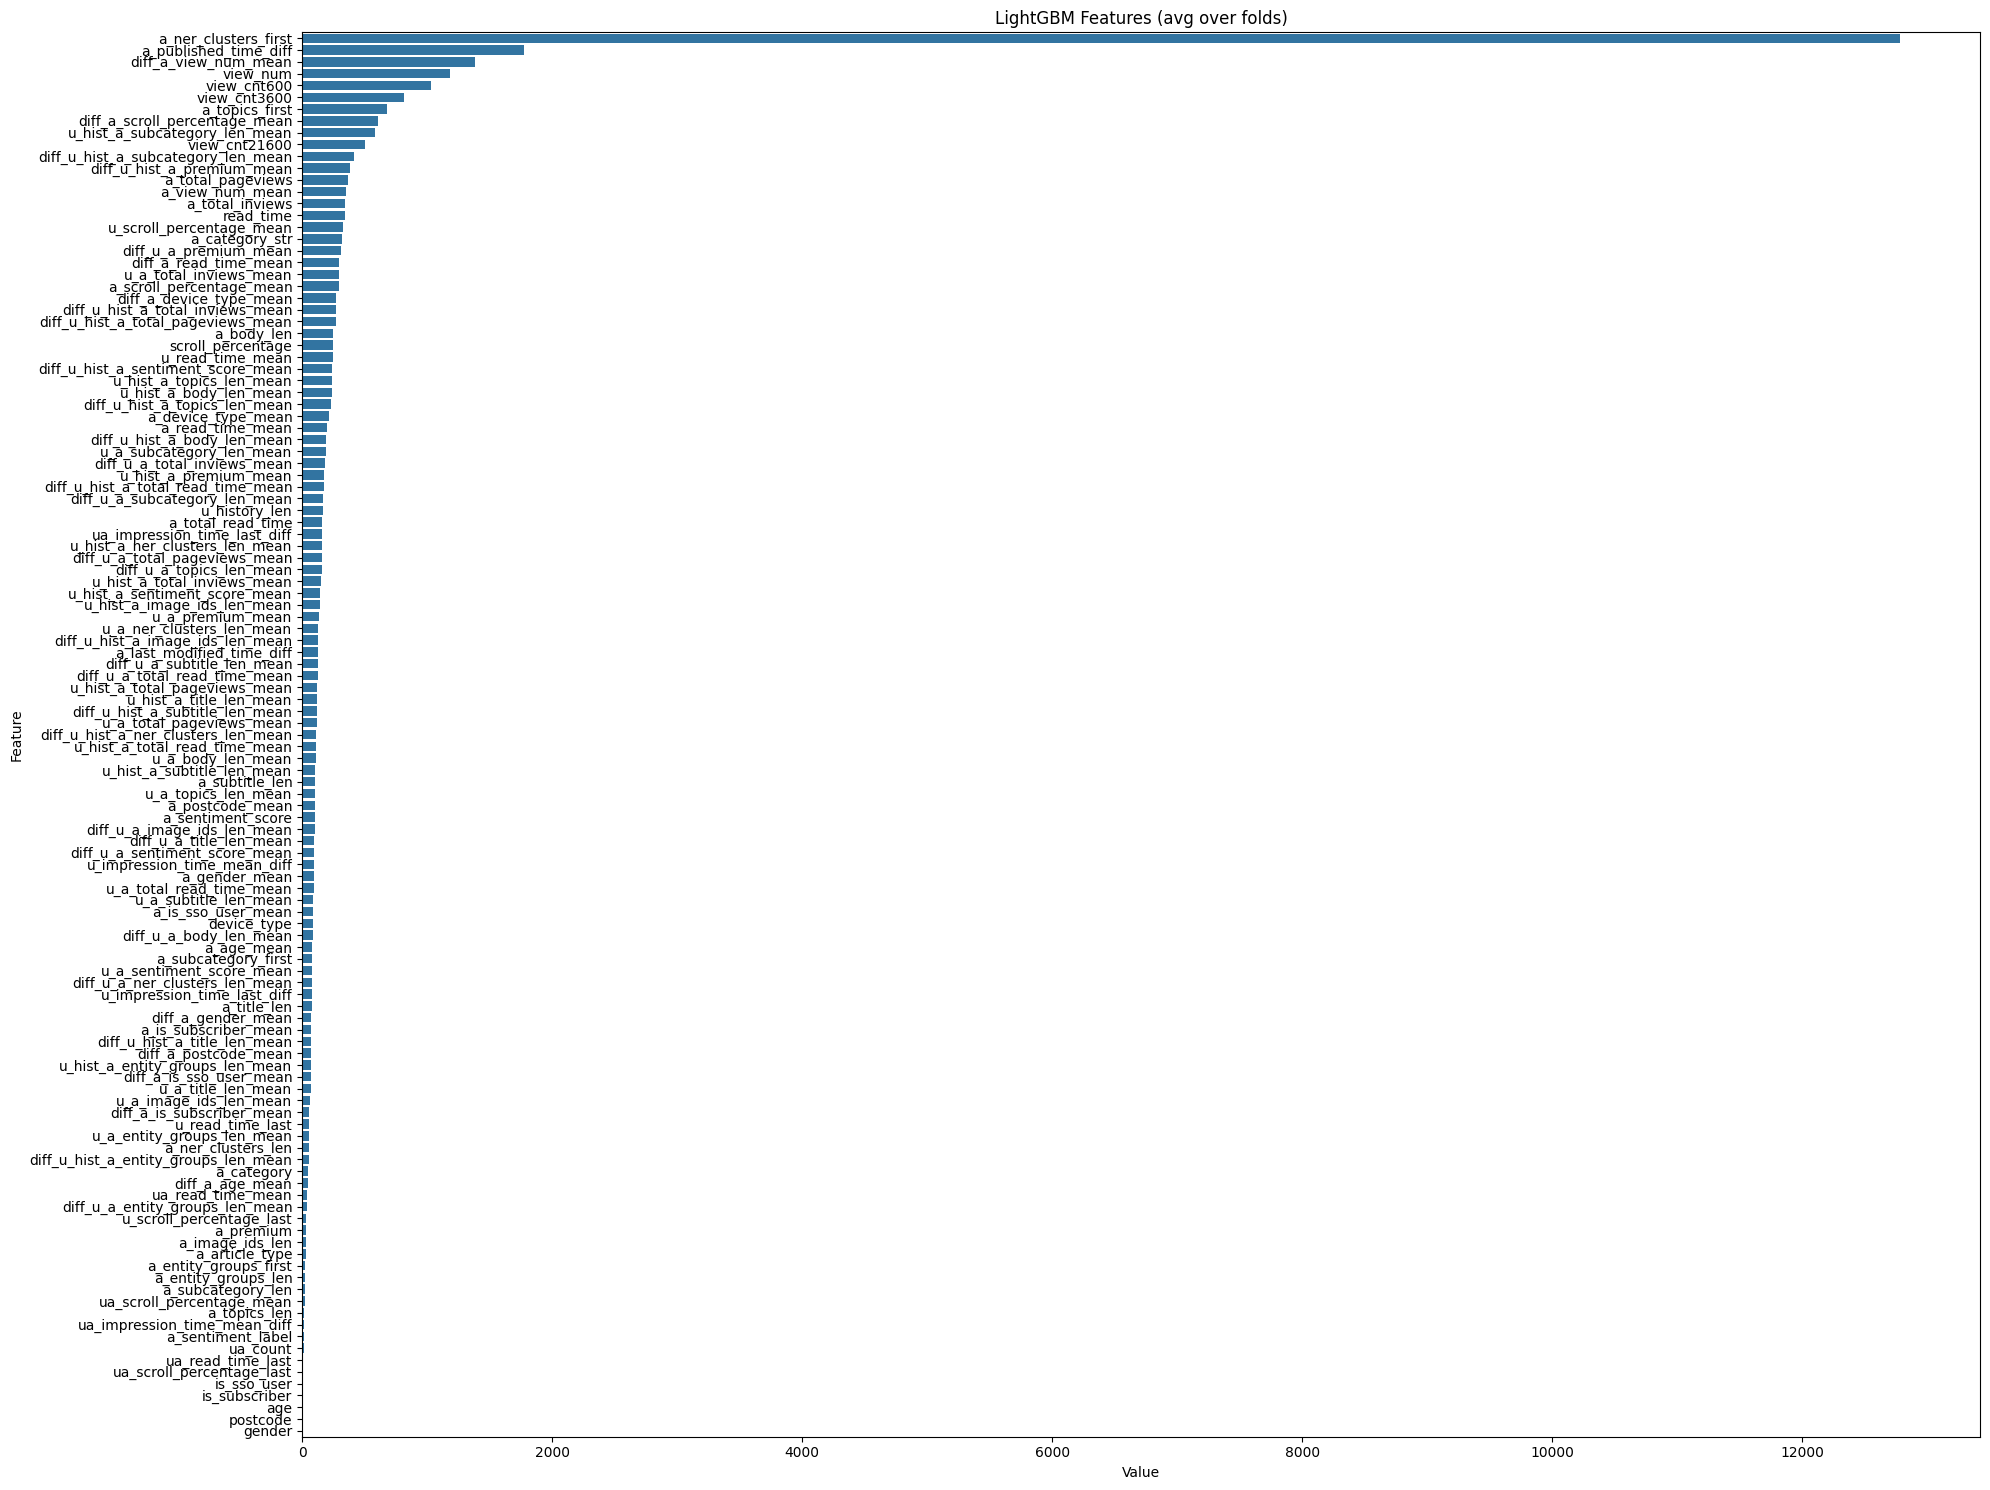

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp_split = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp_split.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

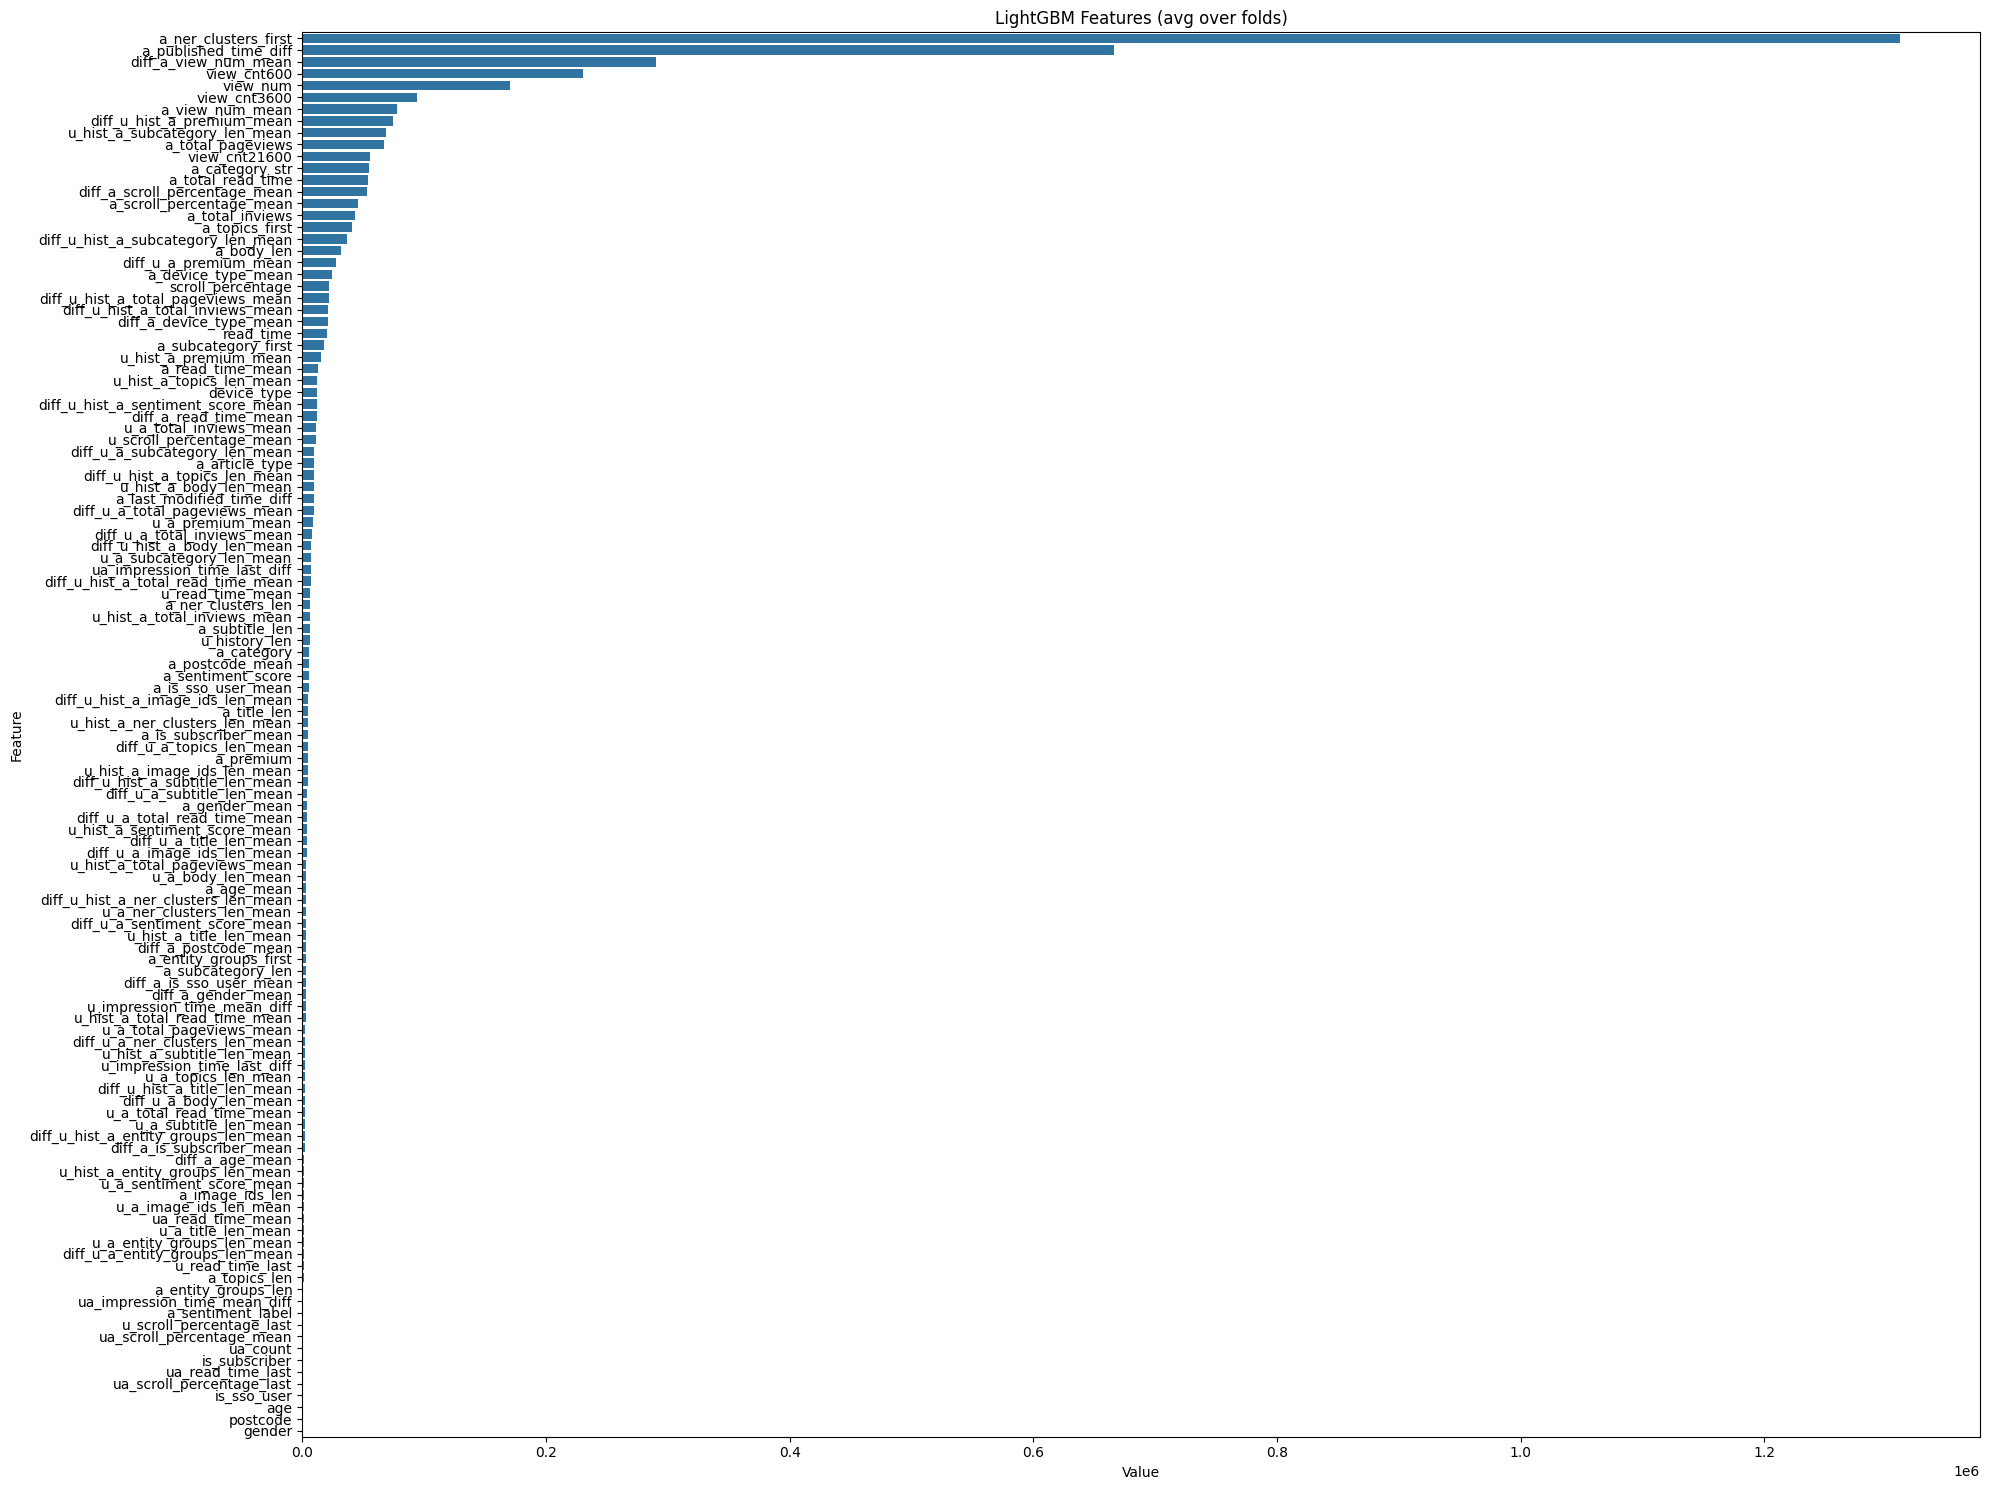

In [26]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [27]:
feature_imp

,Value,Feature
0,0.000000e+00,gender
1,0.000000e+00,postcode
2,3.842660e+01,age
3,1.675444e+02,is_sso_user
4,1.995694e+02,ua_scroll_percentage_last
5,2.048144e+02,ua_read_time_last
6,3.637619e+02,is_subscriber
7,5.172070e+02,ua_count
8,5.749071e+02,ua_scroll_percentage_mean
9,6.866221e+02,u_scroll_percentage_last


In [28]:
# small data
# [68] training's ndcg@5: 0.68384	training's ndcg@10: 0.708506	valid_1's ndcg@5: 0.550625	valid_1's ndcg@10: 0.59301
# 90% negatie sampling [96]	training's ndcg@5: 0.70648	training's ndcg@10: 0.727916	valid_1's ndcg@5: 0.55037	valid_1's ndcg@10: 0.592454
# 80% [84] training's ndcg@5: 0.724863	training's ndcg@10: 0.743467	valid_1's ndcg@5: 0.546675	valid_1's ndcg@10: 0.589225
# 50% [48] training's ndcg@5: 0.791471	training's ndcg@10: 0.801367	valid_1's ndcg@5: 0.549047	valid_1's ndcg@10: 0.590969
# full data
# full, valid_frac=0.5 [72]	training's ndcg@5: 0.676216	training's ndcg@10: 0.701085	valid_1's ndcg@5: 0.554916	valid_1's ndcg@10: 0.596697
#	full, valid_frac=0.25	[72]	training's ndcg@5: 0.676216	training's ndcg@10: 0.701085	valid_1's ndcg@5: 0.555081	valid_1's ndcg@10: 0.596856 -> 0.25で問題なさそう
# under sampling: 0.8 [84]	training's ndcg@5: 0.718681	training's ndcg@10: 0.737356	valid_1's ndcg@5: 0.554494	valid_1's ndcg@10: 0.596234 -> いったんこれでいく
# under sampling: 0.5 [85]	training's ndcg@5: 0.791716	training's ndcg@10: 0.801159	valid_1's ndcg@5: 0.549173	valid_1's ndcg@10: 0.591309

# testに含まれないfeatureを使っていたので修正、featureの数40個ちょっと + bugちょっと修正
# small data
# [179]	training's ndcg@5: 0.727879	training's ndcg@10: 0.743617	valid_1's ndcg@5: 0.542041	valid_1's ndcg@10: 0.583972
# full data
# [71] valid_frac=0.25	training's ndcg@5: 0.666762	training's ndcg@10: 0.689943	valid_1's ndcg@5: 0.537423	valid_1's ndcg@10: 0.580449
# validで学習, [71]	training's ndcg@5: 0.649776	training's ndcg@10: 0.676771	valid_1's ndcg@5: 0.649776	valid_1's ndcg@10: 0.676771
# small data add feature
# [21]	training's ndcg@5: 0.673465	training's ndcg@10: 0.697794	valid_1's ndcg@5: 0.585802	valid_1's ndcg@10: 0.621771

# featureを40くらい->120に増やしてOptuna一回目、データ多すぎたのでfrac_train=0.6, valid=0.2, lr=0.02, importance=0もそこそこある -> itr増やすと数個に減る
# small data again, lr=0.05, early stopping=40
# [293]	training's ndcg@5: 0.785899	training's ndcg@10: 0.797273	valid_1's ndcg@5: 0.624458	valid_1's ndcg@10: 0.653404
# 0 feature削る (7個) -> 若干過学習っぽくなってる？いったん削るのやめる
# [497]	training's ndcg@5: 0.813702	training's ndcg@10: 0.823218	valid_1's ndcg@5: 0.62413	valid_1's ndcg@10: 0.652956

# dataのサイズがでかすぎるのが問題だが、出せる範囲でいったんsubしてみたい。
# full size tarin frac=0.6, valid=0.25, n features=120, lr=0.05
# [562]	training's ndcg@5: 0.756472	training's ndcg@10: 0.767894	valid_1's ndcg@5: 0.6163	valid_1's ndcg@10: 0.645803
# full size importance 0 削る (7個) -> いったん見送り
# [475]	training's ndcg@5: 0.753473	training's ndcg@10: 0.765269	valid_1's ndcg@5: 0.614346	valid_1's ndcg@10: 0.644336

# small, scroll percentageとreadtimeが0のものを削除 -> trainは精度上がったがvalidは上がらなかったのでやめとく
# [359]	training's ndcg@5: 0.805963	training's ndcg@10: 0.815656	valid_1's ndcg@5: 0.611978	valid_1's ndcg@10: 0.645153



